In [53]:
import requests
import pandas as pd
import numpy as np
import googlemaps
import pprint
import time
import sys
import urllib
from PIL import Image
from IPython.display import display
from IPython.display import Image


In [54]:
def df_add_place_name(df_for_place_name):
    
    df_add_place = df_for_place_name.copy()
    
    df_add_place['place_name'] = df_add_place['bar_pub_name'] + " " + df_add_place['borough']
    
    return df_add_place

In [55]:
def df_chunker(seq, size, origin):
    
    rm_dest_list=[]
    time_list = []
    distance_list = []
    
    seq = seq.copy()

    for pos in range(0, len(seq), size):
        destinations = seq[pos:pos + size]['place_name']
        result = gmaps.distance_matrix(origin, destinations, mode = 'walking', units='imperial')
        
        for i in range(0, size):       

            if(pos+i==len(seq)):
                break
            
            if(result["rows"][0]["elements"][i]["status"]!="OK"):
                rm_dest_list.append(destinations[pos+i])
            else:
                time_list.append(result["rows"][0]["elements"][i]["duration"]["value"])
                distance_list.append(result["rows"][0]["elements"][i]["distance"]["value"])
    
#         dest_list.append(seq[pos:pos + size]['place_name'])
        time.sleep(2.5)

    seq=seq[~seq['place_name'].isin(rm_dest_list)]
    seq=seq.copy()
    seq.reset_index(drop=True,inplace=True)

    return seq,time_list,distance_list


In [56]:
def rebuild_bar_list(df,tl,dl):
    
    nxt_df = df.copy()
    nxt_tl = tl.copy()
    nxt_dl = dl.copy()
    
    nxt = pd.DataFrame(list(zip(nxt_df.to_list(), nxt_tl, nxt_dl)), columns=['bar_pub_name','time_to_next', 'distance_to_next'])
    nxt.drop(nxt[nxt.distance_to_next == 0].index, inplace=True)
    
    return nxt
    

In [57]:
def get_nxt_bar(df_nxt_bar_print):
    
    nxt = pd.DataFrame()
    nxt = df_nxt_bar_print.copy()
    
    cont = nxt[nxt.time_to_next == nxt.time_to_next.min()]['bar_pub_name'].iloc[0]
    
    return cont


In [58]:
def process_image_url(image_url):
    with urllib.request.urlopen(image_url) as url:
        with open('temp.jpg', 'wb') as f:
            f.write(url.read())
    ig=Image(image_url, width = 500)
    display(ig)


In [61]:
def main():
    
    
    df = pd.read_csv('./../data/nyc_bar_crawl_sample2.csv',index_col=False)
    df = df_add_place_name(df).copy()
        
    tl = []
    dl = []
    
    df_nxt = df.copy()
    
    while True:
        # get user input
        x = input('Input current location/bar name in the format: [location/bar_name<space>borough] | c to continue | x to exit\n')
        
        if(len(df_nxt)==0):
            print("\n\nCongratulations for completing the bar crawl 🍻 🏆 🥳 ")
            break
        
        if(x=='x'):
            print("\n\n Continue the bar crawl by inputting the last visited bar the next time 👋")
            break

        df_nxt = df_add_place_name(df_nxt).copy()
        
        if x=='c':
            try:
                sq,tl,dl = df_chunker(df_nxt,25,cont)
                df_nxt=sq.copy()
            except:
                print("Invalid input; try again")
                continue
        elif x=='x':
            break
        else:
            try:
                sq,tl,dl = df_chunker(df_nxt,25,x)
                df_nxt=sq.copy()
            except:
                print("Invalid location; try again")
                continue

        df_nxt = rebuild_bar_list(df_nxt['place_name'], tl, dl).copy()

        cont = get_nxt_bar(df_nxt)
        print("Head to this bar next: ",cont,"\n")

        df_nxt = df_nxt.merge(df, left_on='bar_pub_name', right_on='place_name', how='inner').drop(columns=['bar_pub_name_x','time_to_next','distance_to_next']).rename(columns={"bar_pub_name_y": "bar_pub_name"}).reset_index(drop=True).copy()
        print(df_nxt[df_nxt.place_name==cont])
        
        cc = df_nxt.loc[df_nxt.place_name==cont]['yelp_image_url'].reset_index().copy()
        cc.drop(columns=['index'],inplace=True)
        
        df_nxt = df_nxt[df_nxt.place_name!=cont].copy()

        try:
            process_image_url(cc.loc[0, 'yelp_image_url'])
        except:
            print("No image available")
            continue


        
        

<ipython-input-61-82c8bc155a6a>:4: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv('./../data/nyc_bar_crawl_sample2.csv',index_col=False)


Input current location/bar name in the format: [location/bar_name<space>borough] | c to continue | x to exit
1515 broadway
Head to this bar next:  ACCENT RESTAURANT & BAR Manhattan 

     bar_id             bar_pub_name    borough  building   address    zip  \
0  41542713  ACCENT RESTAURANT & BAR  Manhattan       429  3 AVENUE  10016   

        phone   latitude  longitude  score  ... day_2_hours_end  \
0  9177508470  40.743103 -73.980018     13  ...            2200   

  day_3_hours_start day_3_hours_end day_4_hours_start  day_4_hours_end  \
0              1000            2245              1000             2300   

  day_5_hours_start  day_5_hours_end  day_6_hours_start  day_6_hours_end  \
0              1030             2300               1100             2200   

                          place_name  
0  ACCENT RESTAURANT & BAR Manhattan  

[1 rows x 31 columns]


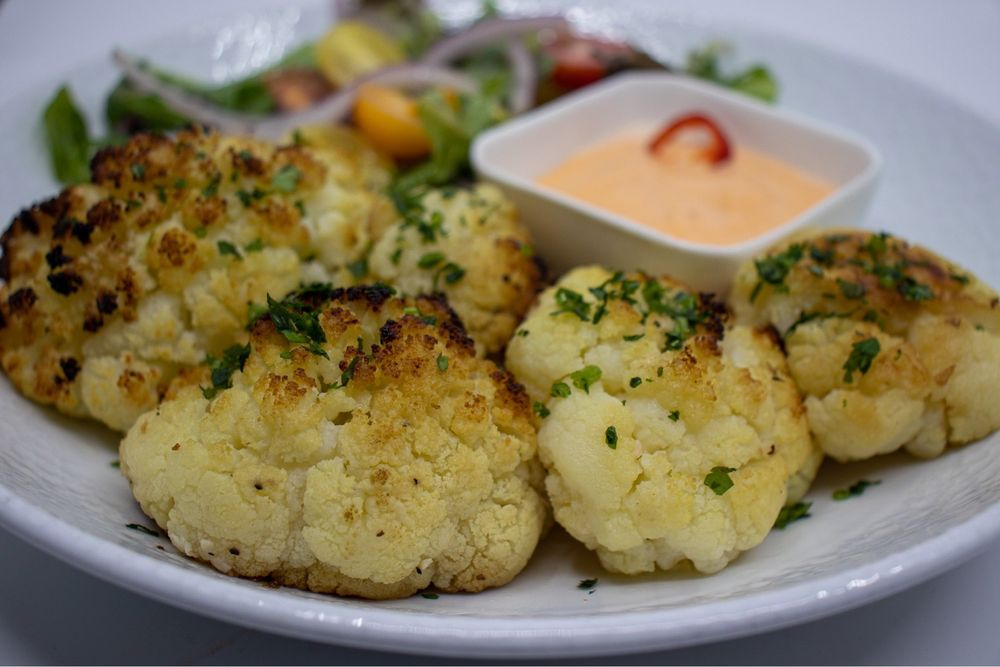

Input current location/bar name in the format: [location/bar_name<space>borough] | c to continue | x to exit
c
Head to this bar next:  SONY HUB, COFFEE BAR Manhattan 

     bar_id          bar_pub_name    borough  building         address    zip  \
0  50045850  SONY HUB, COFFEE BAR  Manhattan        25  MADISON AVENUE  10010   

        phone   latitude  longitude  score  ... day_2_hours_end  \
0  2128337349  40.742039 -73.987117      7  ...            1800   

  day_3_hours_start day_3_hours_end day_4_hours_start  day_4_hours_end  \
0               700            1800               700             1800   

  day_5_hours_start  day_5_hours_end  day_6_hours_start  day_6_hours_end  \
0               700             1800                700             1800   

                       place_name  
0  SONY HUB, COFFEE BAR Manhattan  

[1 rows x 31 columns]


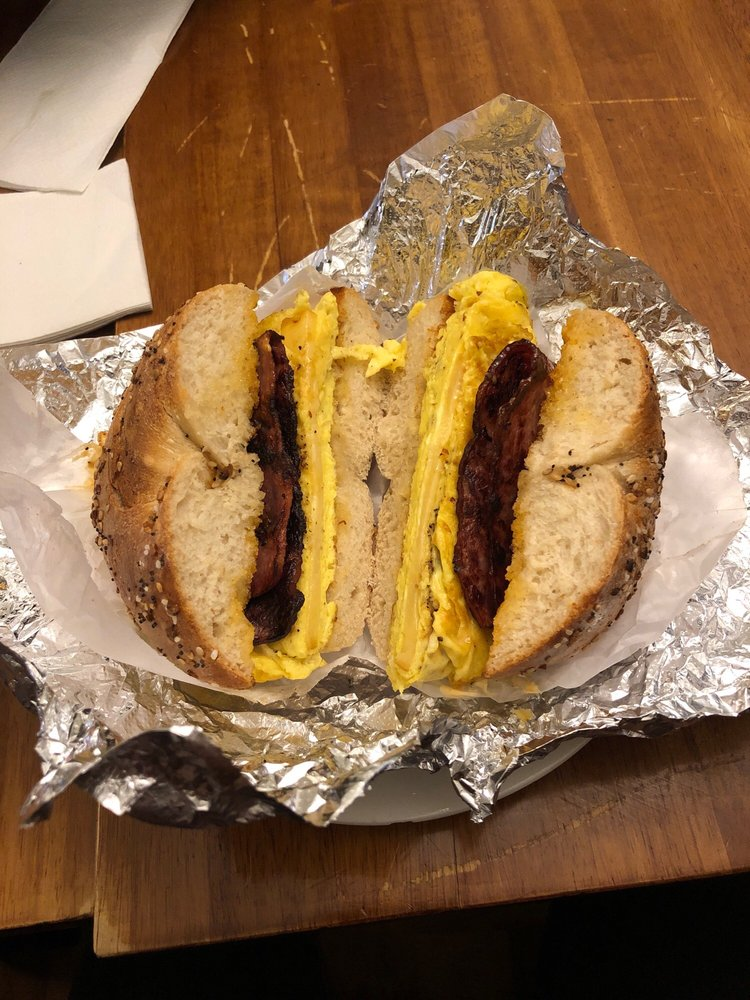

Input current location/bar name in the format: [location/bar_name<space>borough] | c to continue | x to exit
c


Congratulations for completing the bar crawl 🍻 🏆 🥳 


In [62]:
if __name__ == '__main__':

    #API Key Import
    api_file = open("google-map-api-key.txt", "r")
    API_KEY = api_file.read()
    api_file.close()


    gmaps = googlemaps.Client(key=API_KEY)
    main()

# 